In [1]:
import time
import bgshr
import scipy.stats
import numpy as np
import pandas
import matplotlib.pylab as plt, matplotlib

plt.rcParams["legend.title_fontsize"] = "xx-small"
matplotlib.rc("xtick", labelsize=7)
matplotlib.rc("ytick", labelsize=7)
matplotlib.rc("axes", labelsize=8)
matplotlib.rc("axes", titlesize=8)
matplotlib.rc("legend", fontsize=6)
plt.rcParams['legend.title_fontsize'] = 'xx-small'

In [2]:
u = 1.5e-8
u_nonsyn = (2.31) / (2.31 + 1) * u
u_fac = u_nonsyn / 1e-8
u_fac

1.0468277945619333

In [3]:
# load the lookup table
table_file = "../lookup_tables/lookup_tbl_equilibrium.csv.gz"
df = bgshr.Util.load_lookup_table(table_file)
df_sub = bgshr.Util.subset_lookup_table(df)
df_sub = df_sub[df_sub["s"] > -0.005]

In [4]:
# extend the lookup table with classic BGS predictions
smin = np.min(np.sort(list(set(df_sub["s"]))))
s_extend = -np.concatenate(([0], np.logspace(-6, 0, 46))) ## this may need to change with future grids
s_extend = s_extend[s_extend < smin]
df_sub = bgshr.ClassicBGS.extend_lookup_table(df_sub, s_extend)

# interpolate between recombination values in the lookup table
u_vals, s_vals, splines = bgshr.Util.generate_cubic_splines(df_sub)
max_r = max(df_sub["r"])
print("maximum recombination distance in table:", max_r)

maximum recombination distance in table: 0.5


In [5]:
ss = np.sort(list(set(df_sub["s"])))

In [6]:
# DFE, from Kim et al (2017?)
shape = 0.215
Ne = 10000
scale = 562.1 / 2 / Ne

weights = bgshr.Util.weights_gamma_dfe(s_vals, shape, scale)

print(weights[:-1].sum())

0.9065491014110855


In [7]:
L = 50000000
rmap = bgshr.Util.load_recombination_map("../data/YRI-2-final.txt.gz", L=L)

In [8]:
# load the bed file
elements_all = bgshr.Util.load_elements("../data/chr2_exons.bed", L=L)
# combine overlapping elements
elements = bgshr.Util.collapse_elements(elements_all)
# subdivide large elements into smaller chunks
elements = bgshr.Util.break_up_elements(elements)

print("Total map length:", rmap(L))
print("Number of exons:", len(elements))

Total map length: 0.7028008588711058
Number of exons: 3115


In [9]:
spacing = 1000
xs = np.arange(500, L, spacing)
time1 = time.time()
Bs = bgshr.Predict.Bvals(xs, s_vals[:-1], splines, L=L, rmap=rmap, elements=elements, max_r=0.5)
time2 = time.time()
print(time2 - time1)

150.97301054000854


In [10]:
B = bgshr.Util.integrate_with_weights(Bs, weights[:-1], u_fac=u_fac)
B

array([0.9836137 , 0.9836137 , 0.9836137 , ..., 0.99525368, 0.99525441,
       0.99525516])

In [11]:
data = np.load("../simulation_outputs/rec_scaled.Q_1.ave_div.1kb.chr2.1-50000000.npz")["arr_0"]
assert len(B) == len(data)

In [12]:
# interference correction for the 50Mb segment
# this takes a while
bmap = scipy.interpolate.CubicSpline(xs, B, bc_type="natural")
n_iter = 2
for i in range(n_iter):
    print("running iteration", i)
    rmap2 = bgshr.Util.adjust_recombination_map(rmap, bmap)
    time1 = time.time()
    Bs2 = bgshr.Predict.Bvals(xs, s_vals[:-1], splines, L=L, rmap=rmap2, elements=elements, max_r=0.5, bmap=bmap)
    time2 = time.time()
    B2 = bgshr.Util.integrate_with_weights(Bs2, weights[:-1], u_fac=u_fac)
    print("finished iteration", i, "in", time2 - time1, "seconds")
    bmap = scipy.interpolate.CubicSpline(xs, B2, bc_type="natural")

running iteration 0
finished iteration 0 in 317.401686668396 seconds
running iteration 1
finished iteration 1 in 320.8698151111603 seconds


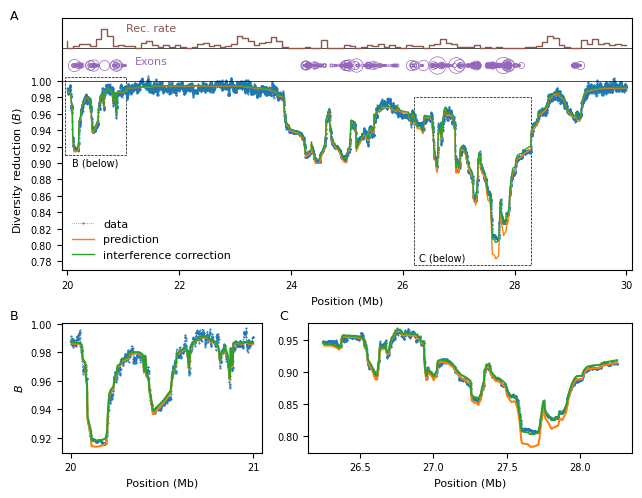

In [13]:
fig = plt.figure(figsize=(6.5, 5))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax1 = plt.subplot2grid((8, 5), (0, 0), colspan=5, rowspan=5)
ax2 = plt.subplot2grid((8, 5), (5, 0), colspan=2, rowspan=3)
ax3 = plt.subplot2grid((8, 5), (5, 2), colspan=3, rowspan=3)

ax1.plot(xs[20000:30000] / 1e6, data[20000:30000], ".:", lw=0.5, ms=1, label="data")
ax1.plot(xs[20000:30000] / 1e6, B[20000:30000], lw=1, label="prediction")
ax1.plot(xs[20000:30000] / 1e6, B2[20000:30000], lw=1, label="interference correction")
xlim = ax1.get_xlim()
ax1.hlines([1, 1.04], xlim[0], xlim[-1], "black", lw=0.5) #, "gray", lw=1, linestyles=":")

labeled = False
for e in elements_all:
    if labeled is False:
        label = "exons"
        labeled = True
    else:
        label = None
    x = np.mean([e[0], e[1]])
    L = e[1] - e[0]
    ax1.plot(x / 1e6, 1.02, "o", ms=0.15 * L ** 0.5, markerfacecolor="none", color=colors[4], markeredgewidth=0.5)

l = 100000
ax1.step(np.linspace(20, 30, 10000000 // l), 
         1.04 + 400000 * np.diff(rmap(np.linspace(20000000, 30000000, 10000000 // l + 1))) / l, 
         lw=1, color=colors[5],
         #label="rec. rate (100kb average)"
        )
         
ax1.set_xlabel("Position (Mb)")
ax1.set_ylabel("Diversity reduction ($B$)")
ax1.yaxis.set_label_coords(-0.065, 0.4)
ax1.set_xlim(19.9, 30.1)
ax1.set_yticks(np.arange(0.78, 1.01, 0.02))
ax1.legend(frameon=False, fontsize=8)

rect = matplotlib.patches.Rectangle((19.95, 0.91), 1.1, 0.095, linestyle="--", edgecolor="k", lw=0.5, facecolor="none")
ax1.add_patch(rect)
ax1.text(20.5, 0.9, "B (below)", va="center", ha="center", fontsize=7)

rect2 = matplotlib.patches.Rectangle((26.2, 0.775), 2.1, 0.205, linestyle="--", edgecolor="k", lw=0.5, facecolor="none")
ax1.add_patch(rect2)
ax1.text(26.7, 0.785, "C (below)", va="center", ha="center", fontsize=7)

ax1.text(21.5, 1.065, "Rec. rate", va="center", ha="center", color=colors[5], fontsize=8)
ax1.text(21.5, 1.025, "Exons", va="center", ha="center", color=colors[4], fontsize=8)

ax2.plot(xs[20000:21000] / 1e6, data[20000:21000], ".:", lw=0.75, ms=1, label="data")
ax2.plot(xs[20000:21000] / 1e6, B[20000:21000], lw=1.5, label="prediction")
ax2.plot(xs[20000:21000] / 1e6, B2[20000:21000], lw=1.5, label="prediction")
ax3.plot(xs[26250:28250] / 1e6, data[26250:28250], ".:", lw=0.75, ms=1, label="data")
ax3.plot(xs[26250:28250] / 1e6, B[26250:28250], lw=1.5, label="prediction")
ax3.plot(xs[26250:28250] / 1e6, B2[26250:28250], lw=1.5, label="prediction")

ax2.set_xlabel("Position (Mb)")
ax3.set_xlabel("Position (Mb)")
ax2.set_ylabel("$B$")

ax2.set_xticks([20, 21])
ax3.set_xticks([26.5, 27, 27.5, 28])

fig.text(0.025, 0.975, "A", va="center", ha="center", fontsize=9)
fig.text(0.025, 0.375, "B", va="center", ha="center", fontsize=9)
fig.text(0.440, 0.375, "C", va="center", ha="center", fontsize=9)

fig.tight_layout()
plt.savefig("../figures/chr2_10Mb.png")